<a href="https://colab.research.google.com/github/Socrates0007/covid-project/blob/main/Covid_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this project is to diagnose **covid19** with the help of Artificial Intelligence(AI).

This research is carried out by Socrates Udosen

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#pytorch related imports 
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

%matplotlib inline


**Project**  **Description** 


This project uses a public available SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1230 CT scans for patients non-infected by SARS-CoV-2, 2482 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil. The aim of this dataset is to encourage the research and development of artificial intelligent methods which are able to identify if a person is infected by SARS-CoV-2 through the analysis of his/her CT scans. As baseline result for this dataset we used an eXplainable Deep Learning approach (xDNN) which we could achieve an F1 score of 97.31% which is very promising.

extraction complete


In [2]:
data_dir = '/content/drive/MyDrive/data_covidd'
train_dir = data_dir+'/train'
valid_dir = data_dir+'/valid'
test_dir = data_dir+'/test'



In [7]:

#Define data transforms with torchvision

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomRotation(30),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) ])

valid_transform = transforms.Compose( [transforms.Resize(225),transforms.CenterCrop(224),
     transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]) ])



#Load the data with ImageLoader 
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transform)
test_data = datasets.ImageFolder(test_dir, transform=valid_transform)

#define data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)




In [4]:
#Label Mapping
cat_to_name = {'0':'healthy ','1':'covid patient'}

In [8]:
#Building and Training a convolutional neural network

model = models.vgg19(pretrained=True)


classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088,4096)),
    ('relu',nn.ReLU()),
    ('fc2', nn.Linear(4096,102)),
    ('output', nn.LogSoftmax(dim=1))]))

for param in model.parameters():
  param.requires_grad = False

model.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

model.to('cuda')

epochs = 20
steps = 0
print_every = 40


#TRAINING LOOP
for epoch in range(epochs):
  running_loss = 0
  for inputs, labels in trainloader:
    steps+=1
    #move input and labels tensors to default device
    inputs,labels = inputs.to("cuda"), labels.to("cuda")
    optimizer.zero_grad()

    logps = model.forward(inputs)
    loss = criterion(logps, labels)

    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
         #validation pass
    if steps==1 or steps%print_every == 0:
      validation_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval()
        for inputs, labels in validationloader:
          inputs, labels = inputs.to("cuda"),labels.to("cuda")
          logps = model.forward(inputs)
          batch_loss = criterion(logps,labels)

          validation_loss += batch_loss.item()

          #calculating the accuracy
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy+=torch.mean(equals.type(torch.FloatTensor)).item()
      print(f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss/print_every:.3f}.. "
            f"Validation loss: {validation_loss/len(validationloader):.3f}.. "
            f"validation accuracy: {accuracy/len(validationloader):.3f}")
      running_loss=0
      model.train()






/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20.. Train loss: 0.114.. Validation loss: 3.687.. validation accuracy: 0.510
Epoch 2/20.. Train loss: 0.445.. Validation loss: 0.757.. validation accuracy: 0.704
Epoch 3/20.. Train loss: 0.508.. Validation loss: 0.632.. validation accuracy: 0.702
Epoch 5/20.. Train loss: 0.152.. Validation loss: 0.578.. validation accuracy: 0.729
Epoch 6/20.. Train loss: 0.328.. Validation loss: 0.639.. validation accuracy: 0.677
Epoch 8/20.. Train loss: 0.139.. Validation loss: 0.477.. validation accuracy: 0.777
Epoch 9/20.. Train loss: 0.292.. Validation loss: 0.468.. validation accuracy: 0.797
Epoch 11/20.. Train loss: 0.118.. Validation loss: 0.498.. validation accuracy: 0.766
Epoch 12/20.. Train loss: 0.256.. Validation loss: 0.570.. validation accuracy: 0.719
Epoch 14/20.. Train loss: 0.100.. Validation loss: 0.458.. validation accuracy: 0.789
Epoch 15/20.. Train loss: 0.252.. Validation loss: 0.542.. validation accuracy: 0.758
Epoch 17/20.. Train loss: 0.093.. Validation loss: 0.495.. va

In [21]:
# To do : save Checkpoint

model.class_to_idx = train_data.class_to_idx
model.to('cpu')


torch.save({
    'arch':'vgg19',
    'state_dict':model.state_dict(),
    'class_to_idx':model.class_to_idx 
},'classifier.pth')

In [25]:
#Load checkpoint and rebuild model

def load_checkpoint(file_path):
  checkpoint=torch.load(file_path)
  model = models.vgg19(pretrained=True)

  for param in model.parameters():
    param.requires_grad = False
  model.class_to_idx = checkpoint['class_to_idx']    
  classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(4096, 102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))
  model.classifier = classifier
  model.load_state_dict(checkpoint['state_dict'])
  return model  


In [26]:
model = load_checkpoint('classifier.pth')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [27]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [34]:
#Inference
def process_image(image):
  # TODO: Process a PIL image for use in a PyTorch model
  img = Image.open(image).convert('RGB')
  resize = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.299,0.244, 0.225])
    ])
  tensor = resize(img)
  return tensor



In [35]:
def imshow(image,ax=None, title= None):
  if ax is None:
    fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  image = std * image + mean
  image = np.clip(image, 0, 1)
  ax.imshow(image)
  return ax

In [36]:
my_processed_img=process_image(test_dir+'/0/Non-Covid (842).png')

<Axes: >

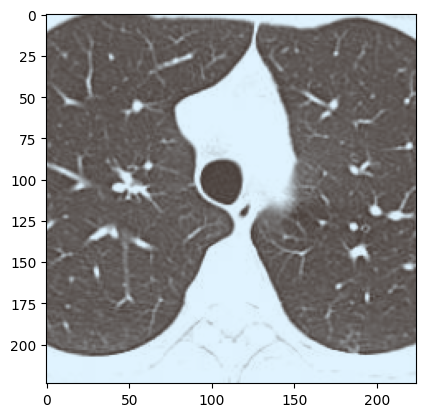

In [37]:
imshow(my_processed_img)

In [38]:
#prediction
def predict(image_path, model, topk=2):
  cleaned_image = process_image(image_path)
  cleaned_image.unsqueeze_(0)
  probabilities = torch.exp(model.forward(cleaned_image))
  top_probabilities, top_labels = probabilities.topk(topk)
  idx_to_class = dict()
  for key, value in model.class_to_idx.items():
    idx_to_class[value] = key
  np_top_labs = top_labels[0].numpy()
  top_flower_labels= list()
  for label in np_top_labs:
    top_flower_labels.append(int(idx_to_class[label]))
  top_preds = [cat_to_name[str(lab)] for lab in top_flower_labels]
  return top_probabilities, top_flower_labels, top_preds

In [39]:
predict(test_dir+'/0/Non-Covid (842).png',model, topk=2)

(tensor([[0.9412, 0.0588]], grad_fn=<TopkBackward0>),
 [0, 1],
 ['healthy ', 'covid patient'])

In [49]:
#display an image along with the top 5 probabilities
def plot(image_path, model):
  plt.figure(figsize=(6,10))
  ax = plt.subplot(2,1,1)

  flower_num = image_path.split('/')[6]
  title_ = cat_to_name[flower_num]

  img = process_image(image_path)
  plt.title(title_)
  imshow(img, ax)
  top_probs, top_labels, top_flowers = predict(image_path, model)
  top_probs = top_probs[0].detach().numpy()

  plt.subplot(2,1,2)

  sns.barplot(x=top_probs, y=top_flowers, color=sns.color_palette()[0])
  plt.show()
  print(top_probs, top_labels, top_flowers) 

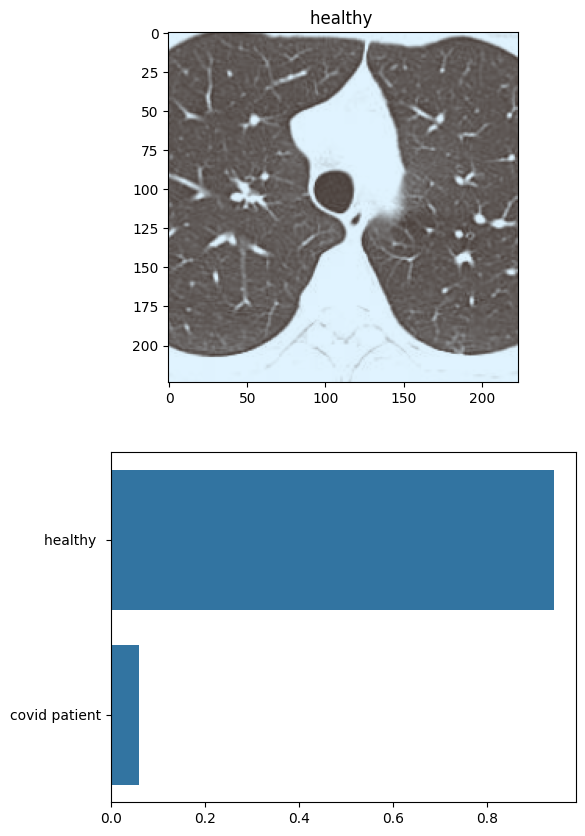

[0.9411887  0.05881105] [0, 1] ['healthy ', 'covid patient']


In [50]:
plot(test_dir+'/0/Non-Covid (842).png', model)